In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


#Import Library

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, mean_absolute_error

#Data

##Load Data

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/rncyspoetra/Hematin-App/refs/heads/main/Machine%20Learning/data_pengeluaran_sintetis%20(final).csv")

##EDA

###Informasi Dataset

In [ ]:
print("=== Informasi Dataset ===")
print(data.info())

=== Informasi Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   income                          10000 non-null  int64  
 1   fixed_expenses                  10000 non-null  int64  
 2   weekly_food_spending            10000 non-null  int64  
 3   weekly_transport_spending       10000 non-null  int64  
 4   subscription_services_count     10000 non-null  int64  
 5   employment_status               10000 non-null  object 
 6   age                             10000 non-null  int64  
 7   last_month_spending             10000 non-null  int64  
 8   savings_last_month              10000 non-null  int64  
 9   next_month_spending_prediction  10000 non-null  float64
 10  saving_suggestion               10000 non-null  object 
dtypes: float64(1), int64(8), object(2)
memory usage: 859.5+ KB
None


###Statistik Deskriptif

In [ ]:
print("\n=== Statistik Deskriptif ===")
print(data.describe())


=== Statistik Deskriptif ===
             income  fixed_expenses  weekly_food_spending  \
count  1.000000e+04    1.000000e+04          1.000000e+04   
mean   3.097630e+07    9.274326e+06          1.551887e+06   
std    1.125461e+07    3.929773e+06          7.767952e+05   
min    1.000000e+06    2.000000e+05          1.000000e+05   
25%    2.197950e+07    6.265750e+06          8.770000e+05   
50%    3.119350e+07    9.018000e+06          1.501000e+06   
75%    4.058300e+07    1.200325e+07          2.213000e+06   
max    5.000000e+07    2.800000e+07          3.000000e+06   

       weekly_transport_spending  subscription_services_count           age  \
count               1.000000e+04                 10000.000000  10000.000000   
mean                5.346234e+05                     4.936400     41.308100   
std                 2.625938e+05                     3.178296     13.865194   
min                 4.000000e+04                     0.000000     18.000000   
25%                 3.057

###Missing Values

In [ ]:
print("\n=== Cek Missing Values ===")
print(data.isnull().sum())


=== Cek Missing Values ===
income                            0
fixed_expenses                    0
weekly_food_spending              0
weekly_transport_spending         0
subscription_services_count       0
employment_status                 0
age                               0
last_month_spending               0
savings_last_month                0
next_month_spending_prediction    0
saving_suggestion                 0
dtype: int64


###Distribusi Saran Penghematan

In [ ]:
print("\n=== Distribusi Target (Saran Penghematan) ===")
print(data["saving_suggestion"].value_counts())


=== Distribusi Target (Saran Penghematan) ===
saving_suggestion
Kurangi langganan aplikasi jasa yang jarang digunakan.                  4485
Sudah cukup hemat, pertahankan kebiasaan menabung.                      3242
Kurangi makan di luar, coba masak sendiri di rumah.                     1389
Cobalah menggunakan transportasi umum seperti angkot, bus, atau KRL.     884
Name: count, dtype: int64


###Visualisasi

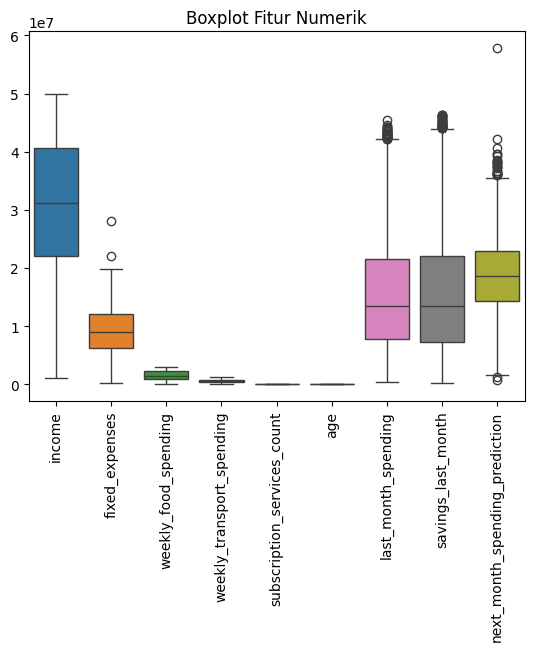

In [ ]:
sns.boxplot(data=data.select_dtypes(include='number'))
plt.xticks(rotation=90)
plt.title("Boxplot Fitur Numerik")
plt.show()

##Fitur dan Target

In [ ]:
X = data.drop(columns=["saving_suggestion", "next_month_spending_prediction"])
y_class_raw = data["saving_suggestion"]
y_reg_raw = data["next_month_spending_prediction"]

label_encoder = LabelEncoder()
y_class_encoded = label_encoder.fit_transform(y_class_raw)
num_classes = len(label_encoder.classes_)

##Preprocessing

In [ ]:
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

##Split Data

In [ ]:
X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split(
    X, y_class_encoded, y_reg_raw, test_size=0.2, random_state=42
)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

#Model

##Model Klasifikasi

In [ ]:
def build_classification_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_processed.shape[1],)))
    hp_units_1 = hp.Int('cls_units_1', min_value=64, max_value=256, step=64)
    hp_dropout = hp.Float('cls_dropout', min_value=0.2, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('cls_learning_rate', values=[1e-2, 1e-3])
    model.add(layers.Dense(units=hp_units_1, activation='relu'))
    model.add(layers.Dropout(rate=hp_dropout))
    model.add(layers.Dense(units=hp_units_1 // 2, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

##Model Regresi

In [ ]:
def build_regression_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_processed.shape[1],)))
    hp_units_1 = hp.Int('reg_units_1', min_value=64, max_value=256, step=64)
    hp_dropout = hp.Float('reg_dropout', min_value=0.2, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('reg_learning_rate', values=[1e-2, 1e-3])
    model.add(layers.Dense(units=hp_units_1, activation='relu'))
    model.add(layers.Dropout(rate=hp_dropout))
    model.add(layers.Dense(units=hp_units_1 // 2, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mean_absolute_error', metrics=['mae'])
    return model

##Tuning Klasifikasi

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner_cls = kt.Hyperband(
    hypermodel=build_classification_model,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='keras_tuner_dir',
    project_name='finance_classification',
    overwrite=True
)
tuner_cls.search(X_train_processed, y_train_class, epochs=15, validation_data=(X_test_processed, y_test_class), callbacks=[stop_early])
best_hps_cls = tuner_cls.get_best_hyperparameters(num_trials=1)[0]
tuned_classifier = tuner_cls.hypermodel.build(best_hps_cls)
tuned_classifier.fit(X_train_processed, y_train_class, epochs=15, validation_data=(X_test_processed, y_test_class), callbacks=[stop_early], verbose=0)

Trial 30 Complete [00h 00m 19s]
val_accuracy: 0.987500011920929

Best val_accuracy So Far: 0.9879999756813049
Total elapsed time: 00h 04m 13s


##Tuning Regresi

In [ ]:
tuner_reg = kt.Hyperband(
    hypermodel=build_regression_model,
    objective=kt.Objective('val_mae', direction='min'),
    max_epochs=15,
    factor=3,
    directory='keras_tuner_dir',
    project_name='finance_regression',
    overwrite=True
)
tuner_reg.search(X_train_processed, y_train_reg, epochs=15, validation_data=(X_test_processed, y_test_reg), callbacks=[stop_early])
best_hps_reg = tuner_reg.get_best_hyperparameters(num_trials=1)[0]
tuned_regressor = tuner_reg.hypermodel.build(best_hps_reg)
tuned_regressor.fit(X_train_processed, y_train_reg, epochs=15, validation_data=(X_test_processed, y_test_reg), callbacks=[stop_early], verbose=0)

Trial 30 Complete [00h 00m 21s]
val_mae: 18038800.0

Best val_mae So Far: 932070.1875
Total elapsed time: 00h 04m 59s


##Training Model Klasifikasi

In [ ]:
cls_model = build_classification_model(best_hps_cls)
cls_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cls_model.fit(X_train_processed, y_train_class, epochs=20, validation_split=0.2)
cls_model.save("model_klasifikasi.h5")
cls_model.save("model_klasifikasi.keras")

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7352 - loss: 0.6871 - val_accuracy: 0.9450 - val_loss: 0.1685
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9321 - loss: 0.1757 - val_accuracy: 0.9625 - val_loss: 0.1161
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9543 - loss: 0.1239 - val_accuracy: 0.9594 - val_loss: 0.0982
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9629 - loss: 0.1029 - val_accuracy: 0.9737 - val_loss: 0.0705
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9652 - loss: 0.0911 - val_accuracy: 0.9794 - val_loss: 0.0597
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9716 - loss: 0.0761 - val_accuracy: 0.9794 - val_loss: 0.0527
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9724 - loss: 0.0659 - val_accuracy: 0.9831 - val_loss: 0.0475
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9729 - loss: 0.0625 - val_accuracy: 0.

##Training Model Regresi

In [ ]:
reg_model = build_regression_model(best_hps_reg)
reg_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
reg_model.fit(X_train_processed, y_train_reg, epochs=20, validation_split=0.2)
reg_model.save("model_regresi.h5")
reg_model.save("model_regresi.keras")

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 392796905144320.0000 - mae: 18822190.0000 - val_loss: 386265098747904.0000 - val_mae: 18636560.0000
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 392117327233024.0000 - mae: 18807130.0000 - val_loss: 385486937915392.0000 - val_mae: 18619316.0000
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 393091412393984.0000 - mae: 18871790.0000 - val_loss: 383210034823168.0000 - val_mae: 18569558.0000
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 387531342348288.0000 - mae: 18709298.0000 - val_loss: 378840778014720.0000 - val_mae: 18474290.0000
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 382274201714688.0000 - mae: 18601906.0000 - val_loss: 371907157295104.0000 - val_mae: 18322302.0000
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 379041601290240.0000 - mae: 18525296.0000 - val_loss: 362202108264448.0000 - val_mae: 18106966.0000
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 

##Evaluasi Model

In [ ]:
loss_cls, accuracy_cls = tuned_classifier.evaluate(X_test_processed, y_test_class)
print(f"Akurasi pada data tes: {accuracy_cls:.2%}")
y_pred_proba = tuned_classifier.predict(X_test_processed)
y_pred_class = np.argmax(y_pred_proba, axis=1)
print("\nLaporan Klasifikasi Model Terbaik:")
print(classification_report(y_test_class, y_pred_class, target_names=label_encoder.classes_))


print("\n\n=== Evaluasi Model Regresi Setelah Fine-Tuning ===")
loss_reg, mae_reg = tuned_regressor.evaluate(X_test_processed, y_test_reg)
print(f"Mean Absolute Error (MAE) pada data tes: Rp {mae_reg:,.2f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0344
Akurasi pada data tes: 98.80%
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Laporan Klasifikasi Model Terbaik:
                                                                      precision    recall  f1-score   support

Cobalah menggunakan transportasi umum seperti angkot, bus, atau KRL.       0.94      0.96      0.95       182
              Kurangi langganan aplikasi jasa yang jarang digunakan.       1.00      1.00      1.00       925
                 Kurangi makan di luar, coba masak sendiri di rumah.       0.98      0.97      0.97       271
                  Sudah cukup hemat, pertahankan kebiasaan menabung.       0.99      0.99      0.99       622

                                                            accuracy                           0.99      2000
                                                           macro avg       0.98      0.98      0.98      2000
                                                  

#Input Manual

In [ ]:
valid_statuses = ['Businessman', 'Freelance', 'Full-time', 'Part-time', 'Contract', 'Student']

print("\n=== Masukkan Data Anda untuk Prediksi ===")
income = float(input("Pendapatan bulanan (contoh: 8000000): "))
fixed_expenses = float(input("Pengeluaran tetap (contoh: 3000000): "))
weekly_food = float(input("Pengeluaran makanan mingguan (contoh: 500000): "))
weekly_transport = float(input("Pengeluaran transport mingguan (contoh: 250000): "))
subscriptions = int(input("Jumlah layanan langganan (contoh: 2): "))
employment_status = input(f"Status pekerjaan {valid_statuses}: ").strip()
while employment_status not in valid_statuses:
    print("❌ Status tidak valid.")
    employment_status = input("Masukkan ulang status pekerjaan: ").strip()
age = int(input("Usia (contoh: 30): "))
last_month_spending = float(input("Pengeluaran bulan lalu (contoh: 6500000): "))
savings_last_month = float(input("Tabungan bulan lalu (contoh: 1500000): "))


=== Masukkan Data Anda untuk Prediksi ===
Pendapatan bulanan (contoh: 8000000): 10000000
Pengeluaran tetap (contoh: 3000000): 5000000
Pengeluaran makanan mingguan (contoh: 500000): 500000
Pengeluaran transport mingguan (contoh: 250000): 50000
Jumlah layanan langganan (contoh: 2): 4
Status pekerjaan ['Businessman', 'Freelance', 'Full-time', 'Part-time', 'Contract', 'Student']: Full-time
Usia (contoh: 30): 33
Pengeluaran bulan lalu (contoh: 6500000): 7000000
Tabungan bulan lalu (contoh: 1500000): 3000000


#Dataframe Input

In [ ]:
user_input_data = pd.DataFrame([{
    "income": income,
    "fixed_expenses": fixed_expenses,
    "weekly_food_spending": weekly_food,
    "weekly_transport_spending": weekly_transport,
    "subscription_services_count": subscriptions,
    "employment_status": employment_status,
    "age": age,
    "last_month_spending": last_month_spending,
    "savings_last_month": savings_last_month
}])

#Inference

In [ ]:
user_input_processed = preprocessor.transform(user_input_data)
suggestion_prediction_proba = tuned_classifier.predict(user_input_processed)
suggestion_prediction_index = np.argmax(suggestion_prediction_proba, axis=1)[0]
suggestion = label_encoder.inverse_transform([suggestion_prediction_index])[0]

spending_prediction = tuned_regressor.predict(user_input_processed)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


#Output

In [ ]:
print("\n📊 HASIL PREDIKSI")
print(f"💰 Prediksi Pengeluaran Bulan Depan: Rp {spending_prediction:,.0f}")
print(f"💡 Saran Penghematan: {suggestion}")


📊 HASIL PREDIKSI
💰 Prediksi Pengeluaran Bulan Depan: Rp 8,379,976
💡 Saran Penghematan: Sudah cukup hemat, pertahankan kebiasaan menabung.
